In [1]:
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import os, csv
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


def get_conservation_path(dataset):
    return f'../../../data/features/conservation/{dataset}'

def get_frustration_path(dataset, mode, id=None):
    if id:
        return f'/home/vit/Projects/flexibility-analysis/data/features/frustration/{dataset}/{mode}/{id}_{id[4]}.done'
    return f'/home/vit/Projects/flexibility-analysis/data/features/frustration/{dataset}/{mode}'

def get_distance_path(dataset):
    return f'/home/vit/Projects/flexibility-analysis/data/features/residue-distances/{dataset}'

def check_consistency(dataset, mode, id):
    fluctuation_path = f'/home/vit/Projects/flexibility-analysis/data/features/fluctuation/{dataset}/fluctuation'
    frustration_path = get_frustration_path(dataset, mode, id)
    pdb_filename = f'{id}_{id[4]}.pdb'
    pdb_file = pdb.PDBFile.read(f'{frustration_path}/FrustrationData/{pdb_filename}')

    # load file to biotite object
    whole_structure = pdb.get_structure(pdb_file, model=1, include_bonds=True)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]

    # some errors with MSE residue
    c_alphas = protein[(protein.atom_name == "CA") 
                       & (protein.element == "C") 
                       & (protein.chain_id == id[4]) # the PDB had to be tweaked before because the chain id can have only one character
                       & (
                             (protein.res_name == 'ALA')
                           | (protein.res_name == 'ARG')
                           | (protein.res_name == 'ASN')
                           | (protein.res_name == 'ASP')
                           | (protein.res_name == 'CYS')
                           | (protein.res_name == 'GLN')
                           | (protein.res_name == 'GLU')
                           | (protein.res_name == 'GLY')
                           | (protein.res_name == 'HIS')
                           | (protein.res_name == 'ILE')
                           | (protein.res_name == 'LEU')
                           | (protein.res_name == 'LYS')
                           | (protein.res_name == 'MET')
                           | (protein.res_name == 'PHE')
                           | (protein.res_name == 'PRO')
                           | (protein.res_name == 'SER')
                           | (protein.res_name == 'THR')
                           | (protein.res_name == 'TRP')
                           | (protein.res_name == 'TYR')
                           | (protein.res_name == 'VAL'))]

    # better check with the fluctuation data too:
    fluctuation_data_len = len(np.load(f'{fluctuation_path}/{id}.npy'))
    if len(c_alphas) != fluctuation_data_len:
        return False
    return True


def get_frustration_stats(dataset, mode, id):
    frustration_filepath = get_frustration_path(dataset, mode, id)
    indices_path = f'/home/vit/Projects/flexibility-analysis/data/features/fluctuation/{dataset}/indices'
    binding_indices = np.load(f'{indices_path}/{id}.npy')

    both_binding_values = []
    one_binding_values = []
    none_binding_values = []
    
    filename = f'{id}_{id[4]}.pdb_{mode}_5adens'
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            if mode == 'configurational':
                residue1 = int(row[0]) - 1
                residue2 = int(row[2]) - 1
                frustration_values = (float(row[6]), float(row[7]), float(row[8]))  

                if residue1 in binding_indices and residue2 in binding_indices:
                    both_binding_values.append(frustration_values)
                elif residue1 in binding_indices or residue2 in binding_indices:
                    one_binding_values.append(frustration_values)
                else:
                    none_binding_values.append(frustration_values)
            else:
                residue = int(row[0]) - 1
                frustration_values = (float(row[6]), float(row[7]), float(row[8]))
                if residue in binding_indices:
                    both_binding_values.append(frustration_values)
                else:
                    none_binding_values.append(frustration_values)

    return both_binding_values, one_binding_values, none_binding_values

def analyze_frustration_stats(frustration_values):
    high_frustration = []
    neutral_frustration = []
    minimal_frustration = []
    for value in frustration_values:
        if value[0] > value[1] and value[0] > value[2]:
            high_frustration.append(value[0])
        elif value[1] > value[2]:
            neutral_frustration.append(value[1])
        else:
            minimal_frustration.append(value[2])
    return high_frustration, neutral_frustration, minimal_frustration

def print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title=None):
    overall_len = len(high_frustration) + len(neutral_frustration) + len(minimal_frustration)
    if title:
        print(title)
    print(f'{len(high_frustration)} ({len(high_frustration) / (overall_len) * 100:.2f}%), average value {sum(high_frustration) / (len(high_frustration) if len(high_frustration) != 0 else 1):.2f}; high frustration')
    print(f'{len(neutral_frustration)} ({len(neutral_frustration) / overall_len * 100:.2f}%), average value {sum(neutral_frustration) / len(neutral_frustration):.2f}; neutral frustration')
    print(f'{len(minimal_frustration)} ({len(minimal_frustration) / overall_len * 100:.2f}%), average value {sum(minimal_frustration) / len(minimal_frustration):.2f}; minimal frustration')
    print()

def load_dataset(dataset, mode):
    frustration_directory = get_frustration_path(dataset, mode)
    both_binding_values = []
    one_binding_values = []
    none_binding_values = []

    for file in os.listdir(frustration_directory):
        file_path = os.path.join(frustration_directory, file)
        id = file.split('_')[0]
        # if exception occured when calculating the frustration
        if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
            continue
        # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
        if not check_consistency(dataset, mode, id):
            continue
        
        # print(f'Processing {id} ...')
        both_binding_value, one_binding_value, none_binding_value = get_frustration_stats(dataset, mode, id)
        both_binding_values.extend(both_binding_value)
        one_binding_values.extend(one_binding_value)
        none_binding_values.extend(none_binding_value)
    
    return both_binding_values, one_binding_values, none_binding_values

In [79]:
both_binding_values_cryptic, one_binding_values_cryptic, none_binding_values_cryptic = load_dataset('cryptobench-dataset', 'configurational')
for values, title in zip((both_binding_values_cryptic, one_binding_values_cryptic, none_binding_values_cryptic), ('Both binding', 'One binding', 'None binding')):
    high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
    print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title)

Both binding
21 (2.33%), average value 0.64; high frustration
756 (83.81%), average value 0.68; neutral frustration
125 (13.86%), average value 0.56; minimal frustration

One binding
516 (2.44%), average value 0.60; high frustration
18480 (87.24%), average value 0.68; neutral frustration
2186 (10.32%), average value 0.57; minimal frustration

None binding
4695 (2.51%), average value 0.60; high frustration
165287 (88.29%), average value 0.67; neutral frustration
17233 (9.20%), average value 0.56; minimal frustration



In [80]:
both_binding_values_rigid, one_binding_values_rigid, none_binding_values_rigid = load_dataset('rigid-dataset', 'configurational')
for values, title in zip((both_binding_values_rigid, one_binding_values_rigid, none_binding_values_rigid), ('Both binding', 'One binding', 'None binding')):
    high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
    print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title)

Both binding
4 (2.05%), average value 0.56; high frustration
177 (90.77%), average value 0.70; neutral frustration
14 (7.18%), average value 0.59; minimal frustration

One binding
203 (2.35%), average value 0.60; high frustration
7748 (89.56%), average value 0.68; neutral frustration
700 (8.09%), average value 0.55; minimal frustration

None binding
4242 (2.60%), average value 0.61; high frustration
147367 (90.34%), average value 0.68; neutral frustration
11512 (7.06%), average value 0.55; minimal frustration



Both stats have small sample size for the 'both binding' class ... So I guess this is a bit useless

Let's take a look at mutational configuration:

In [3]:
both_binding_values_cryptic, _, none_binding_values_cryptic = load_dataset('cryptobench-dataset', 'mutational')
for values, title in zip((both_binding_values_cryptic, none_binding_values_cryptic), ('Both binding', 'None binding')):
    high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
    print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title)

NameError: name 'load_dataset' is not defined

In [82]:
both_binding_values_rigid, _, none_binding_values_rigid = load_dataset('rigid-dataset', 'mutational')
for values, title in zip((both_binding_values_rigid, none_binding_values_rigid), ('Both binding', 'None binding')):
    high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
    print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title)

Both binding
94 (2.03%), average value 0.54; high frustration
3490 (75.52%), average value 0.64; neutral frustration
1037 (22.44%), average value 0.58; minimal frustration

None binding
3286 (1.96%), average value 0.53; high frustration
120659 (72.10%), average value 0.63; neutral frustration
43401 (25.93%), average value 0.58; minimal frustration



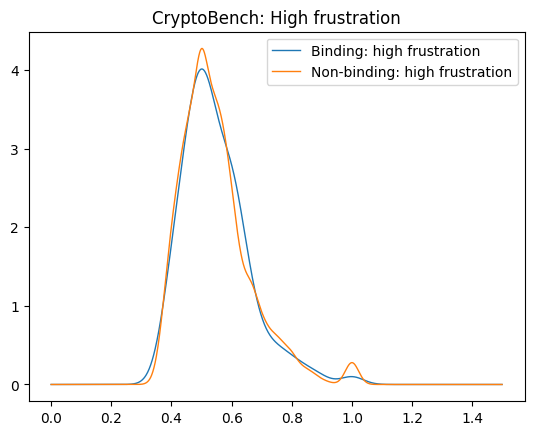

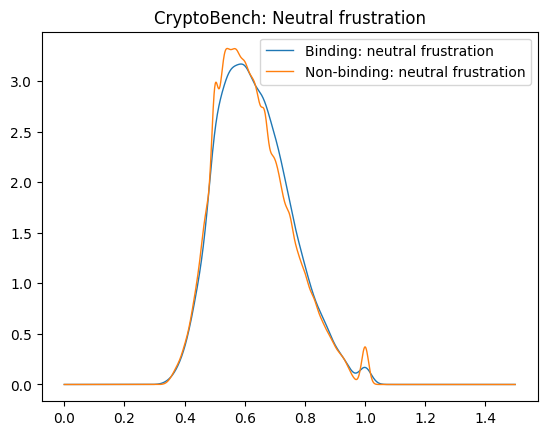

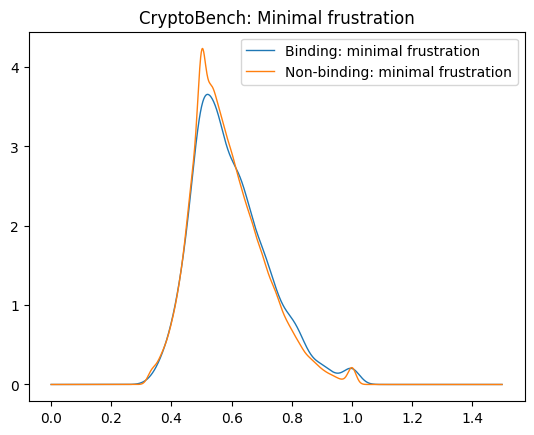

In [ ]:
def plot_kde(data1, data2, labels=['', ''], weighted=False, title=''):   
    data1, data2 = np.array(data1), np.array(data2)

    kdea = scipy.stats.gaussian_kde(data1)
    kdeb = scipy.stats.gaussian_kde(data2)

    all = np.hstack((data1, data2))
    # kdeall = scipy.stats.gaussian_kde(all)
    grid = np.arange(0, 1.5, 0.001)

    wa = kdea(grid)
    wb = kdeb(grid)
    if weighted:
        wa *= (len(data1)/float(len(all)))
        wb *= (len(data2)/float(len(all)))
    
    fig, ax = plt.subplots()
    ax.plot(grid, wa, lw=1, label = labels[0])
    ax.plot(grid, wb, lw=1, label = labels[1])
    # ax.plot(grid, kdeall(grid), color="crimson", lw=2, label = "pdf")

    plt.title(title)
    plt.legend()
    plt.show()

high_frustration_binding, neutral_frustration_binding, minimal_frustration_binding = analyze_frustration_stats(both_binding_values_cryptic)
high_frustration_nonbinding, neutral_frustration_nonbinding, minimal_frustration_nonbinding = analyze_frustration_stats(none_binding_values_cryptic)

plot_kde(high_frustration_binding, high_frustration_nonbinding, title='CryptoBench: High frustration', labels=['Binding: high frustration', 'Non-binding: high frustration'])
plot_kde(neutral_frustration_binding, neutral_frustration_nonbinding, title='CryptoBench: Neutral frustration', labels=['Binding: neutral frustration', 'Non-binding: neutral frustration'])
plot_kde(minimal_frustration_binding, minimal_frustration_nonbinding, title='CryptoBench: Minimal frustration', labels=['Binding: minimal frustration', 'Non-binding: minimal frustration'])

TODO: frustration vs. apo-holo distance (if frustration represents the 'dissatisfaction' of the residue then it might be correlated with the apo-holo movement) - plot for [0-2] and [0-inf] distance intervals

In [4]:
def get_frustration_and_distance(dataset, id, mode='mutational'):
    frustration_filepath = get_frustration_path(dataset, mode, id)
    distances_path = get_distance_path(dataset)

    if not os.path.exists(f'{distances_path}/{id}.npy'):
        return [], []

    frustration = []
    
    filename = f'{id}_{id[4]}.pdb_{mode}_5adens'
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        next(csv_reader, None)  # skip the headers
        residues_count = 0
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            if mode == 'configurational':
                raise NotImplementedError
                # residue1 = int(row[0]) - 1
                # residue2 = int(row[2]) - 1
                # frustration_values = (float(row[6]), float(row[7]), float(row[8]))  
                # if residue1 in binding_indices and residue2 in binding_indices:
                #     both_binding_values.append(frustration_values)
                # elif residue1 in binding_indices or residue2 in binding_indices:
                #     one_binding_values.append(frustration_values)
                # else:
                #     none_binding_values.append(frustration_values)
            else:
                frustration_values = (float(row[6]), float(row[7]), float(row[8]))
                frustration.append(frustration_values)
            residues_count += 1

        distances = np.load(f'{distances_path}/{id}.npy')
        if len(distances) != residues_count:
            return [], []

    return frustration, distances

def load_dataset_with_distance(dataset, mode):
    frustration_directory = get_frustration_path(dataset, mode)
    frustration = []
    distances = []
    for file in os.listdir(frustration_directory):
        file_path = os.path.join(frustration_directory, file)
        id = file.split('_')[0]
        # if exception occured when calculating the frustration
        if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
            continue
        # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
        if not check_consistency(dataset, mode, id):
            continue
        
        # print(f'Processing {id} ...')
        this_frustration, this_distances = get_frustration_and_distance(dataset, id)
        if len(this_frustration) == 0:
            continue
        frustration.extend(this_frustration)
        distances.extend(this_distances)

    return np.array(frustration), np.array(distances)

DISTANCE_CLIP_THRESHOLD = 10

def boxplot(frustration, distances, xlim=(0, DISTANCE_CLIP_THRESHOLD), ylim=None, title='', labels=['', '', '']):
    plt.figure(figsize=(12, 6))
    colors = ['pink', 'lightblue', 'gold']
    x = np.array(list(range(xlim[0], xlim[1])))

    for i in x:
        indices = np.where(distances == i)

        boxplot = plt.boxplot(frustration[indices],0,'',positions=[i-0.2,i,i+0.2],widths=0.1, patch_artist=True)
        # fill with color:
        for i, patch in enumerate(boxplot['boxes']):
            patch.set_facecolor(colors[i])
    
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, labels)
    
    plt.xlabel('Distance')

    plt.xticks(x, x)
    if ylim:
        plt.ylim(0, ylim)
    plt.ylabel('Frustration')
    plt.title(title)
    plt.tight_layout()
    plt.show()


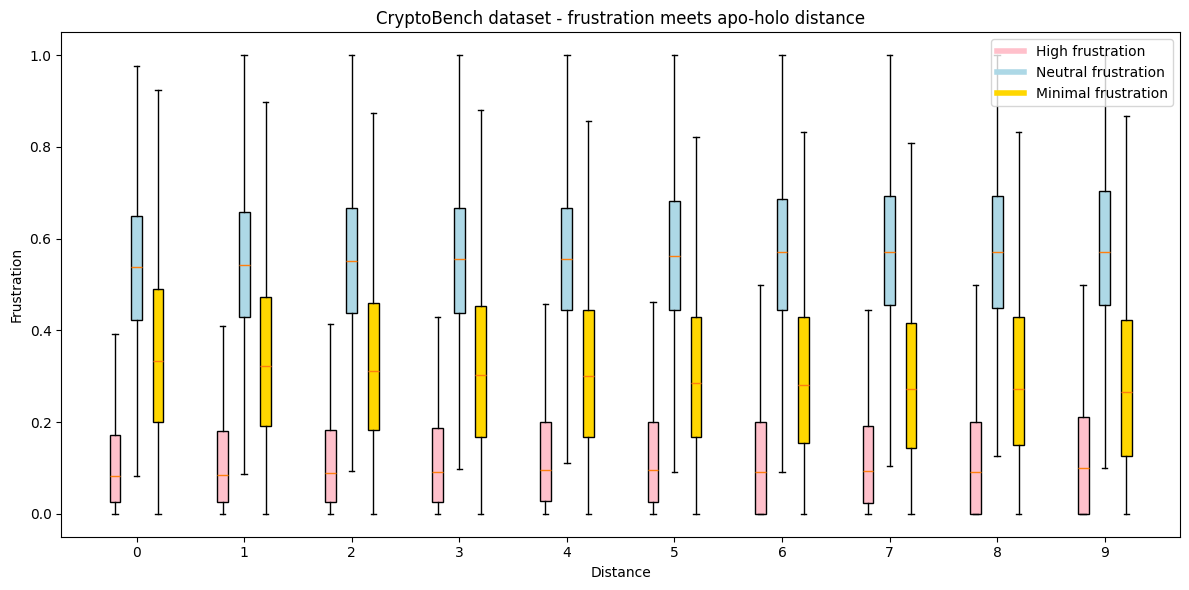

In [ ]:
frustration, distances = load_dataset_with_distance('cryptobench-dataset', 'mutational')

assert len(frustration) == len(distances)

rounded_distances = np.rint(distances)
rounded_distances = np.clip(rounded_distances, 0, DISTANCE_CLIP_THRESHOLD)

boxplot(frustration, rounded_distances, title='CryptoBench dataset - frustration meets apo-holo distance', labels=['High frustration', 'Neutral frustration', 'Minimal frustration'])

This graph is a bit skewed because it takes ALL values of minimal/neutral/high frustration. Let's take only those values where the minimal/neutral/high frustration is the highest.

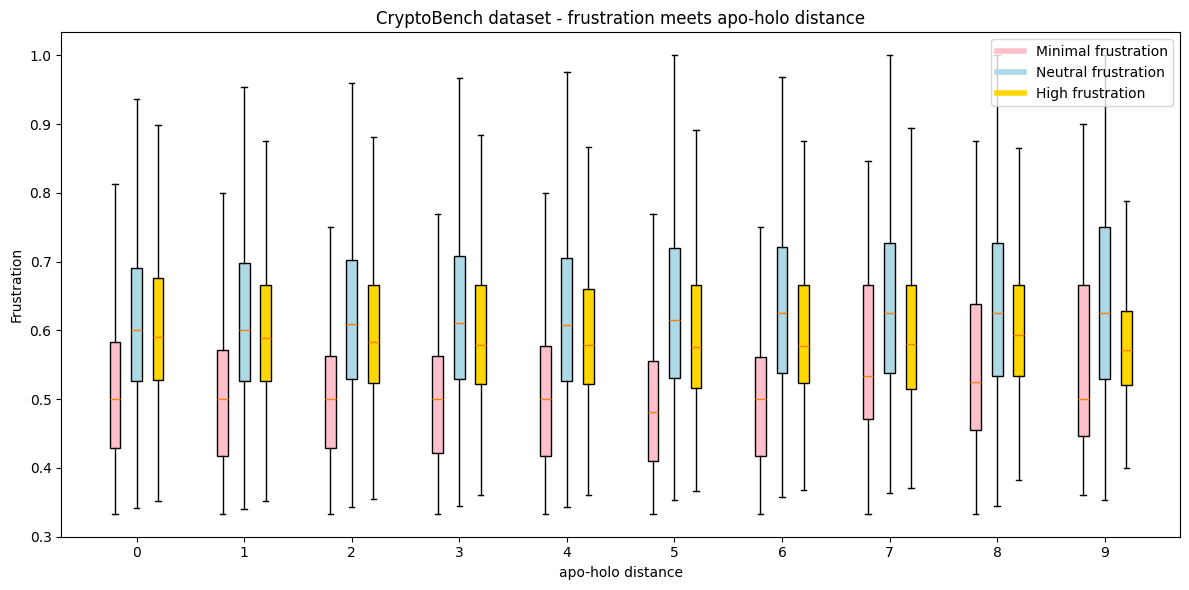

In [36]:
def boxplot2(frustration, distances, xlim=(0, DISTANCE_CLIP_THRESHOLD), ylim=None, title='', labels=['', '', '']):
    plt.figure(figsize=(12, 6))
    colors = ['pink', 'lightblue', 'gold']
    x = np.array(list(range(xlim[0], xlim[1])))


    minimal_frustration, minimal_frustration_distance = frustration[np.argmax(frustration, axis=1) == 0][:,0], distances[np.argmax(frustration, axis=1) == 0]
    neutral_frustration, neutral_frustration_distance = frustration[np.argmax(frustration, axis=1) == 1][:,1], distances[np.argmax(frustration, axis=1) == 1]
    high_frustration, high_frustration_distance = frustration[np.argmax(frustration, axis=1) == 2][:,2], distances[np.argmax(frustration, axis=1) == 2]

    x = np.array(list(range(xlim[0], xlim[1])))

    for i in x:
        indices1 = np.where(minimal_frustration_distance == i)
        indices2 = np.where(neutral_frustration_distance == i)
        indices3 = np.where(high_frustration_distance == i)
        boxplot = plt.boxplot([minimal_frustration[indices1], neutral_frustration[indices2], high_frustration[indices3]],0,'',positions=[i-0.2,i,i+0.2],widths=0.1, patch_artist=True)
    
        # fill with color:
        for i, patch in enumerate(boxplot['boxes']):
            patch.set_facecolor(colors[i])

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, labels)
    
    plt.xlabel('apo-holo distance')

    plt.xticks(x, x)
    if ylim:
        plt.ylim(0, ylim)
    plt.ylabel('Frustration')
    plt.title(title)
    plt.tight_layout()
    plt.show()

boxplot2(frustration, rounded_distances, title='CryptoBench dataset - frustration meets apo-holo distance', labels=['Minimal frustration', 'Neutral frustration', 'High frustration'])

In [13]:
def barplot_frustration_frequence(frustration, distances, xlim=(0, DISTANCE_CLIP_THRESHOLD), title='', labels=['', '', '']):
    plt.figure(figsize=(12, 6))
    colors = ['pink', 'lightblue', 'gold']

    minimal_frustration_distance = distances[np.argmax(frustration, axis=1) == 2]
    neutral_frustration_distance = distances[np.argmax(frustration, axis=1) == 1]
    high_frustration_distance = distances[np.argmax(frustration, axis=1) == 0]

    x = np.array(list(range(xlim[0], xlim[1])))

    for i in x:
        indices1 = np.where(minimal_frustration_distance == i)[0]
        indices2 = np.where(neutral_frustration_distance == i)[0]
        indices3 = np.where(high_frustration_distance == i)[0]

        overall_count = len(indices1) + len(indices2) + len(indices3)
        
        frequence1 = len(indices1) / overall_count
        frequence2 = len(indices2) / overall_count
        frequence3 = len(indices3) / overall_count

        import math  
        assert math.isclose(frequence1 + frequence2 + frequence3, 1)

        bar = plt.bar([i-0.2, i, i+0.2], [frequence3, frequence2, frequence1], width=0.1)

        # fill with color:
        for i, patch in enumerate(bar.patches):
            patch.set_facecolor(colors[i])

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, labels)
    
    plt.xlabel('apo-holo distance')

    plt.xticks(x, x)
    plt.ylabel('Frequence')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def clip_distances(distances):
    rounded_distances = np.rint(distances)
    rounded_distances = np.clip(rounded_distances, 0, DISTANCE_CLIP_THRESHOLD)
    return rounded_distances


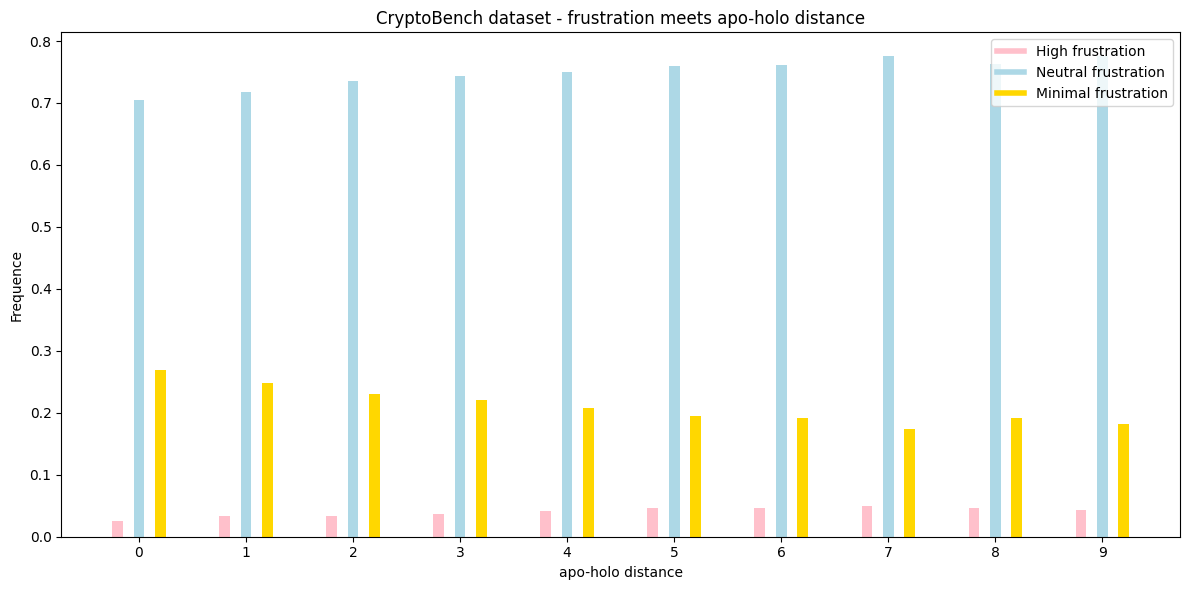

In [ ]:
barplot_frustration_frequence(frustration, rounded_distances, title='CryptoBench dataset - frustration meets apo-holo distance', labels=['High frustration', 'Neutral frustration', 'Minimal frustration'])

Do it for both dataset combined ..

In [ ]:
cryptobench_frustration, cryptobench_distances = load_dataset_with_distance('cryptobench-dataset', 'mutational')
assert len(cryptobench_frustration) == len(cryptobench_distances)
cryptobench_distances = clip_distances(cryptobench_distances)

rigid_frustration, rigid_distances = load_dataset_with_distance('rigid-dataset', 'mutational')
assert len(rigid_frustration) == len(rigid_distances)
rigid_distances = clip_distances(rigid_distances)


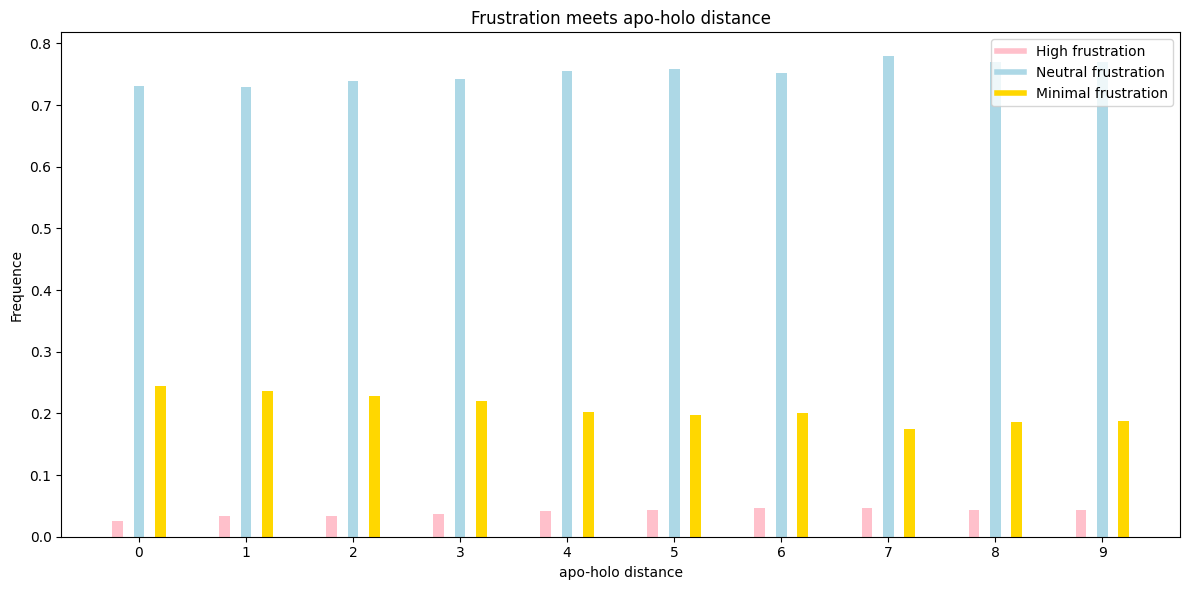

In [16]:
frustration = np.concatenate((cryptobench_frustration, rigid_frustration), axis=0)
rounded_distances = np.concatenate((cryptobench_distances, rigid_distances), axis=0)

barplot_frustration_frequence(frustration, rounded_distances, title='Frustration meets apo-holo distance', labels=['High frustration', 'Neutral frustration', 'Minimal frustration'])

split the dataset into chunks and do a t-test ...

In [43]:
def load_splitted_dataset_with_distance(datasets, split_count, mode):

    frustration = [[] for _ in range(split_count)]
    distances = [[] for _ in range(split_count)]

    for dataset in datasets:
        frustration_directory = get_frustration_path(dataset, mode)
        for i, file in enumerate(os.listdir(frustration_directory)):
            split_index = int(i / (len(os.listdir(frustration_directory)) / split_count))
            file_path = os.path.join(frustration_directory, file)
            id = file.split('_')[0]
            # if exception occured when calculating the frustration
            if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
                continue
            # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
            if not check_consistency(dataset, mode, id):
                continue
            
            # print(f'Processing {id} ...')
            this_frustration, this_distances = get_frustration_and_distance(dataset, id)
            if len(this_frustration) == 0:
                continue
            frustration[split_index].extend(this_frustration)
            distances[split_index].extend(this_distances)

    return frustration, distances

split_count = 10
frustration, distances = load_splitted_dataset_with_distance(['rigid-dataset', 'cryptobench-dataset'], split_count, 'mutational')

minimal_frequences = [[[] for _ in range(DISTANCE_CLIP_THRESHOLD)] for _ in range(split_count)]
neutral_frequences = [[[] for _ in range(DISTANCE_CLIP_THRESHOLD)] for _ in range(split_count)]
high_frequences = [[[] for _ in range(DISTANCE_CLIP_THRESHOLD)] for _ in range(split_count)]

for i in range(len(frustration)):
    frustration[i] = np.array(frustration[i])
    distances[i] = np.array(distances[i])
    distances[i] = clip_distances(distances[i])

    minimal_frustration_distance = distances[i][np.argmax(frustration[i], axis=1) == 2]
    neutral_frustration_distance = distances[i][np.argmax(frustration[i], axis=1) == 1]
    high_frustration_distance = distances[i][np.argmax(frustration[i], axis=1) == 0]
        
    for ii in range(DISTANCE_CLIP_THRESHOLD):
        minimal_indices = np.where(minimal_frustration_distance == ii)[0]
        neutral_indices = np.where(neutral_frustration_distance == ii)[0]
        high_indices = np.where(high_frustration_distance == ii)[0]

        overall_count = len(minimal_indices) + len(neutral_indices) + len(high_indices)

        minimal_frequences[i][ii].append(len(minimal_indices) / overall_count)
        neutral_frequences[i][ii].append(len(neutral_indices) / overall_count)
        high_frequences[i][ii].append(len(high_indices) / overall_count)



In [50]:
from scipy import stats

print('Minimal frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same')
print(stats.ttest_rel([i[0] for i in minimal_frequences], [i[9] for i in minimal_frequences]))

print()
print('Neutral frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same')
print(stats.ttest_rel([i[9] for i in neutral_frequences], [i[0] for i in neutral_frequences]))

print()
print('High frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same')
print(stats.ttest_rel([i[9] for i in high_frequences], [i[0] for i in high_frequences]))


Minimal frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same
TtestResult(statistic=array([5.5811779]), pvalue=array([0.00034243]), df=array([9]))

Neutral frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same
TtestResult(statistic=array([3.56076843]), pvalue=array([0.00611192]), df=array([9]))

High frustration - Null hypothesis = the distribution of apo-holo-distance=0 and apo-holo-distance=9 is the same
TtestResult(statistic=array([2.39897008]), pvalue=array([0.03996532]), df=array([9]))


Minimal frustration - Null hypothesis = the distribution of apo-holo-distance=1 and apo-holo-distance=9 is the same
TtestResult(statistic=array([4.39508919]), pvalue=array([0.00031118]), df=array([19]))

Neutral frustration - Null hypothesis = the distribution of apo-holo-distance=1 and apo-holo-distance=9 is the same
TtestResult(statistic=array([3.37267781]), pvalue=array([0.0031959]), df=array([19]))

High frustration - Null hypothesis = the distribution of apo-holo-distance=1 and apo-holo-distance=9 is the same
TtestResult(statistic=array([1.67564563]), pvalue=array([0.11018672]), df=array([19]))

In [5]:
colors = ['pink', 'lightblue', "gold"]
legend_labels = ['High frustration', 'Neutral frustration', 'Minimal frustration']

def print_plots(data, labels=['', ''], dataset=''):
    plt.figure(figsize=(12, 6))

    for i, values in enumerate(data):
        high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
        # print_frustration_stats(high_frustration, neutral_frustration, minimal_frustration, title)
        boxplot = plt.boxplot([minimal_frustration, neutral_frustration, high_frustration],0,'',positions=[i-0.2,i,i+0.2],widths=0.1, patch_artist=True)
        for i, patch in enumerate(boxplot['boxes']):
            patch.set_facecolor(colors[i])

    x = np.arange(0, len(data))

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, legend_labels)

    plt.xticks(x, labels)
    plt.ylabel('Frustration')
    plt.title(f'Frustration for binding and non-binding residues in {dataset} dataset')
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 6))

    for i, values in enumerate(data):
        high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(values)
        overall_count = len(high_frustration) + len(neutral_frustration) + len(minimal_frustration)

        minimal_frustration_frequence = len(minimal_frustration) / overall_count
        neutral_frustration_frequence = len(neutral_frustration) / overall_count
        high_frustration_frequence = len(high_frustration) / overall_count

        import math  
        assert math.isclose(minimal_frustration_frequence + neutral_frustration_frequence + high_frustration_frequence, 1)

        bar = plt.bar([i-0.2, i, i+0.2], [high_frustration_frequence, neutral_frustration_frequence, minimal_frustration_frequence], width=0.1)

        # fill with color:
        for i, patch in enumerate(bar.patches):
            patch.set_facecolor(colors[i])

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, legend_labels)
    plt.xticks(x, labels)
    plt.ylabel('Frequence')
    plt.title(f'Frequence of minimal/neutral/high frustration')
    plt.tight_layout()
    plt.show()

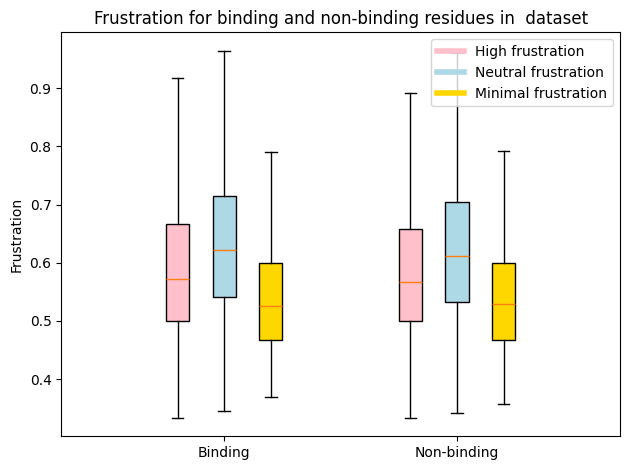

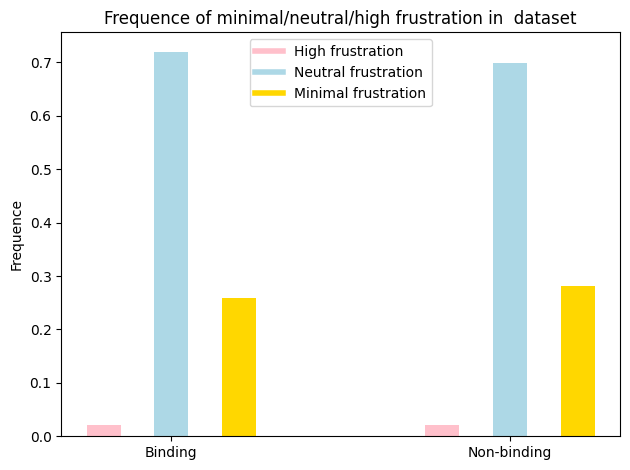

In [ ]:
both_binding_values_cryptic, _, none_binding_values_cryptic = load_dataset('cryptobench-dataset', 'mutational')
labels = ['Binding', 'Non-binding']
print_plots([both_binding_values_cryptic, none_binding_values_cryptic], labels=labels)

Add also rigid to the previous graph ... 

In [5]:
high_frustration, neutral_frustration, minimal_frustration = analyze_frustration_stats(both_binding_values_cryptic)

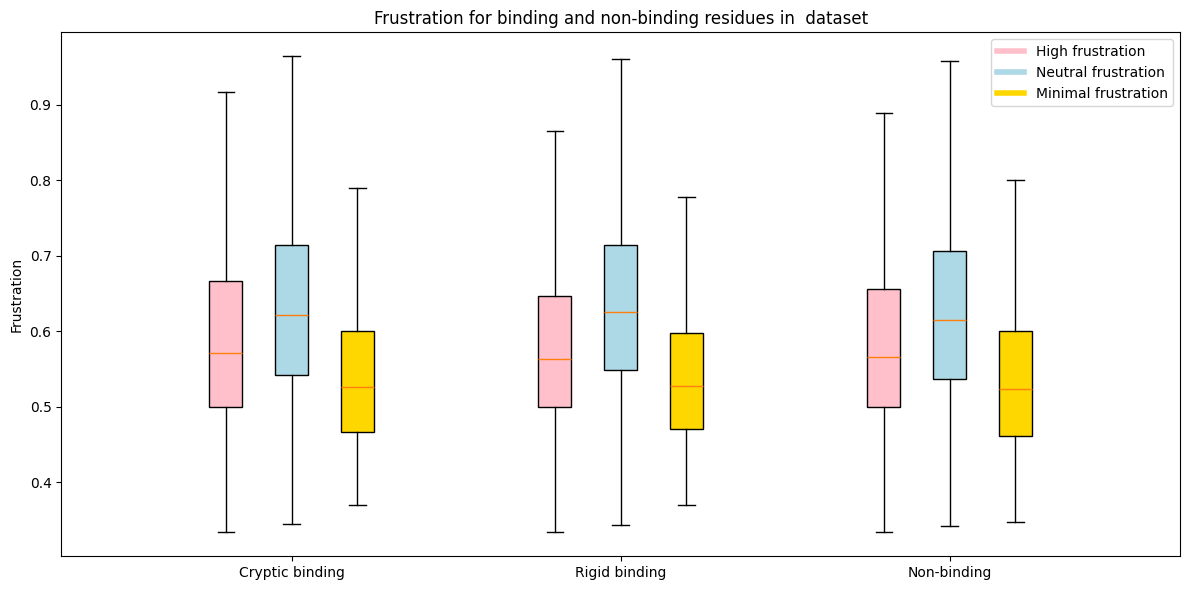

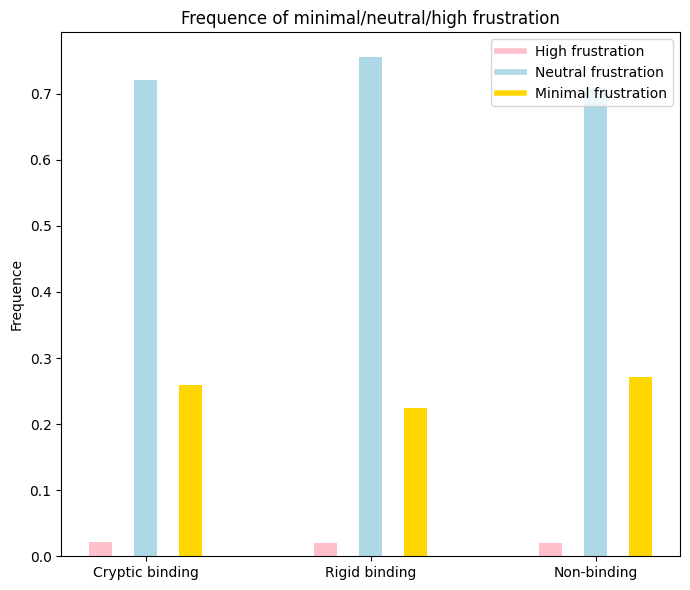

In [ ]:
both_binding_values_cryptic, _, none_binding_values_cryptic = load_dataset('cryptobench-dataset', 'mutational')
both_binding_values_rigid, _, none_binding_values_rigid = load_dataset('rigid-dataset', 'mutational')
labels = ['Cryptic binding', 'Rigid binding', 'Non-binding']
none_binding_values = []
none_binding_values.extend(none_binding_values_cryptic)
none_binding_values.extend(none_binding_values_rigid)
print_plots([both_binding_values_cryptic, both_binding_values_rigid, none_binding_values], labels=labels)

In [ ]:
def get_frustration_and_conservation(dataset, id, mode='mutational'):
    frustration_filepath = get_frustration_path(dataset, mode, id)
    conservation_path = get_conservation_path(dataset)

    if not os.path.exists(f'{conservation_path}/{id}.npy'):
        return [], []

    frustration = []
    
    filename = f'{id}_{id[4]}.pdb_{mode}_5adens'
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        next(csv_reader, None)  # skip the headers
        residues_count = 0
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            if mode == 'configurational':
                raise NotImplementedError
                # residue1 = int(row[0]) - 1
                # residue2 = int(row[2]) - 1
                # frustration_values = (float(row[6]), float(row[7]), float(row[8]))  
                # if residue1 in binding_indices and residue2 in binding_indices:
                #     both_binding_values.append(frustration_values)
                # elif residue1 in binding_indices or residue2 in binding_indices:
                #     one_binding_values.append(frustration_values)
                # else:
                #     none_binding_values.append(frustration_values)
            else:
                frustration_values = (float(row[6]), float(row[7]), float(row[8]))
                frustration.append(frustration_values)
            residues_count += 1

        conservation = (np.load(f'{conservation_path}/{id}.npy') > 0).astype(int)
        if len(conservation) != residues_count:
            return [], []

    return frustration, conservation

def load_dataset_with_conservation(dataset, mode):
    frustration_directory = get_frustration_path(dataset, mode)
    frustration = []
    conservation = []
    for file in os.listdir(frustration_directory):
        file_path = os.path.join(frustration_directory, file)
        id = file.split('_')[0]
        # if exception occured when calculating the frustration
        if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
            continue
        # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
        if not check_consistency(dataset, mode, id):
            continue
        
        # print(f'Processing {id} ...')
        this_frustration, this_conservation = get_frustration_and_conservation(dataset, id)
        if len(this_frustration) == 0:
            continue
        frustration.extend(this_frustration)
        conservation.extend(this_conservation)

    return np.array(frustration), np.array(conservation)


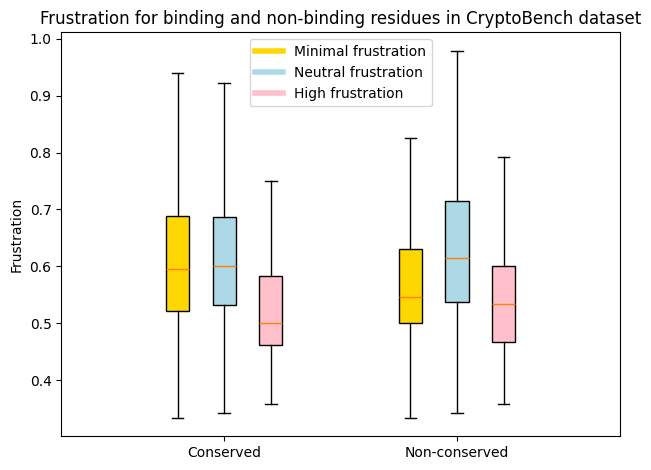

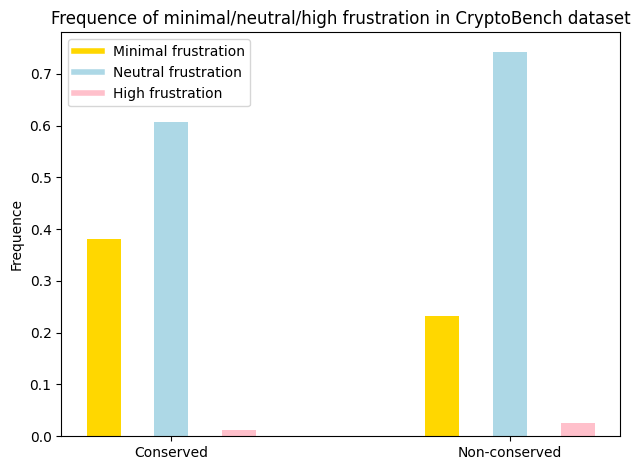

In [7]:
frustration, conservation = load_dataset_with_conservation('cryptobench-dataset', 'mutational')
conserved_frustration = frustration[conservation == 1]
nonconserved_frustration = frustration[conservation == 0]
labels = ['Conserved', 'Non-conserved']
print_plots(conserved_frustration, nonconserved_frustration, labels=labels, dataset='CryptoBench')

In [ ]:
nonconserved_frustration.shape, nonconserved_frustration

(115396, 3)

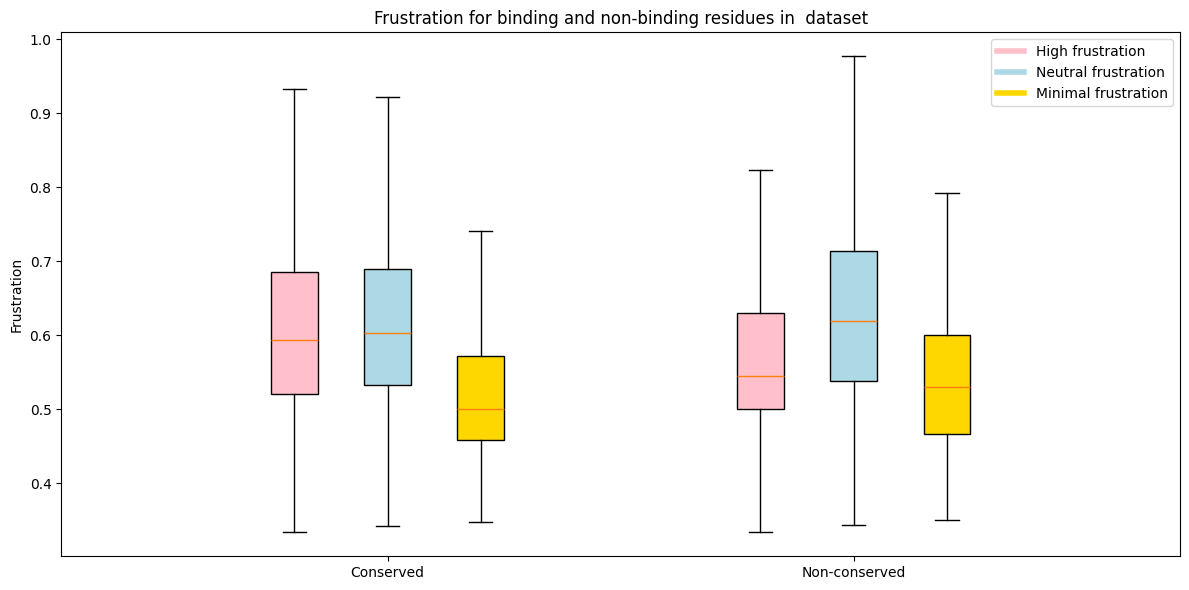

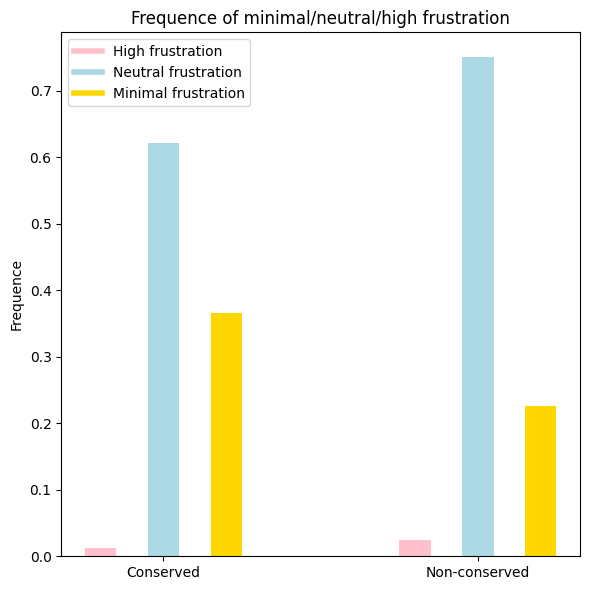

In [65]:
# rigid_frustration, rigid_conservation = load_dataset_with_conservation('rigid-dataset', 'mutational')
# cryptobench_frustration, cryptobench_conservation = load_dataset_with_conservation('cryptobench-dataset', 'mutational')
# conserved_frustration = rigid_frustration[rigid_conservation == 1]
# nonconserved_frustration = rigid_frustration[rigid_conservation == 0]

# assert len(conserved_frustration) + len(nonconserved_frustration) == len(rigid_frustration)
# 
# conserved_frustration = np.concatenate((conserved_frustration, cryptobench_frustration[cryptobench_conservation == 1]), axis=0)
# nonconserved_frustration = np.concatenate((nonconserved_frustration, cryptobench_frustration[cryptobench_conservation == 0]), axis=0)
# labels = ['Conserved', 'Non-conserved']

print_plots([conserved_frustration, nonconserved_frustration], labels=labels)

### TODO:
1. how the PAIR moved between apo-holo (needs to be recalculated for each pair!!!)
2. do the frequency again, but now for both-binding, one-binding, none-binding - for each of these categories, let's have three bars - minimal neutral and high frustration!
3. similarly can be done for conservation

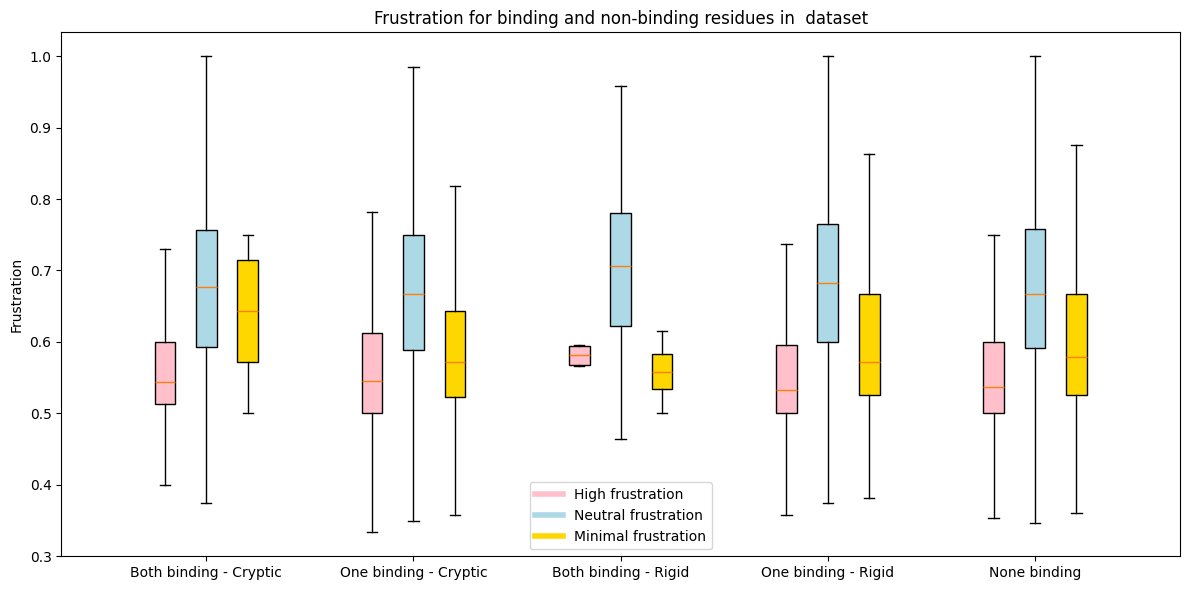

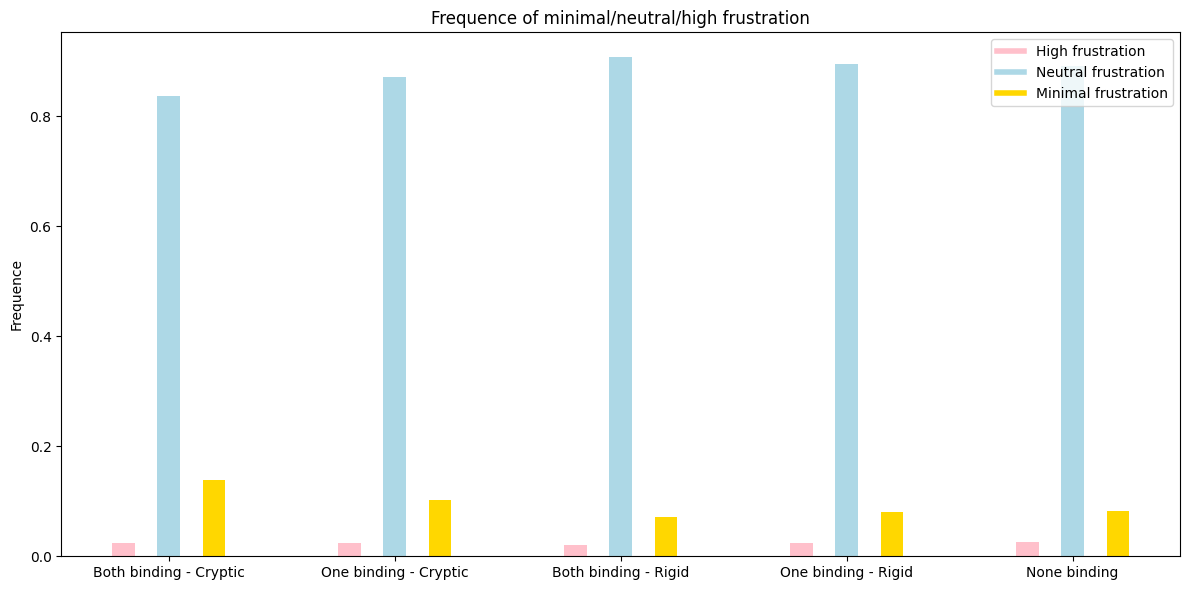

In [6]:
# both_binding_values_cryptic, one_binding_values_cryptic, none_binding_values_cryptic = load_dataset('cryptobench-dataset', 'configurational')
# both_binding_values_rigid, one_binding_values_rigid, none_binding_values_rigid = load_dataset('rigid-dataset', 'configurational')
# 
# none_binding_values = none_binding_values_rigid
# none_binding_values.extend(none_binding_values_cryptic)
# labels = ['Both binding - Cryptic', 'One binding - Cryptic', 'Both binding - Rigid', 'One binding - Rigid', 'None binding']

print_plots([both_binding_values_cryptic, one_binding_values_cryptic,
             both_binding_values_rigid, one_binding_values_rigid, none_binding_values], labels=labels)